In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 

import plot

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


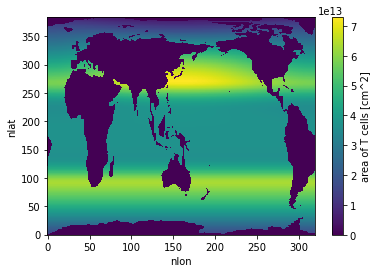

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area.plot()

In [4]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.32:36719 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/35014/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
experiments = [
    'piControl',
    'historical',
    'SSP1-2.6',
    'SSP2-4.5',
    'SSP3-7.0',
    'SSP5-8.5',
]

time_slice = {
    'historical': slice("1990-01-15", "2015-01-15"),
    'SSP1-2.6': slice("2086-01-15", "2101-01-15"),
    'SSP2-4.5': slice("2086-01-15", "2101-01-15"),
    'SSP3-7.0': slice("2086-01-15", "2101-01-15"),
    'SSP5-8.5': slice("2086-01-15", "2101-01-15"),
}

varlist = [
    'photoC_TOT_zint_100m',
    'photoC_diat_zint_100m',
    'photoC_diaz_zint_100m',
    'photoC_sp_zint_100m',
    'POC_FLUX_100m', 
]

In [6]:
dsets_epoch = {}
for experiment in experiments:

    if experiment == 'piControl': 
        continue
        
    ds_list = []
    for variable in varlist:
        xp_func = xp.persist_ds(cu.read_CESM_var, 
                                name=f'epoch-{experiment}-{variable}', 
                                trust_cache=True,)
        
       
        ds_list.append(
            xp_func(
                time_slice=time_slice[experiment], 
                variable=variable, 
                experiment=experiment,
                mean_dims=['member_id', 'time'],
            )
        )

    dsets_epoch[experiment] = xr.merge(ds_list)
    
dsets_epoch

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-photoC_sp_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-historical-POC_FLUX_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP1-2.6-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP1-2.6-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP1-2.6-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP1-2.6-photoC_sp_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP1-2.6-POC_FLUX_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP2-4.5-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP2-4.5-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP2-4.5-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP2-4.5-photoC_sp_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP2-4.5-POC_FLUX_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP3-7.0-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP3-7.0-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP3-7.0-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP3-7.0-photoC_sp_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP3-7.0-POC_FLUX_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP5-8.5-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP5-8.5-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP5-8.5-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP5-8.5-photoC_sp_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/epoch-SSP5-8.5-POC_FLUX_100m.nc


{'historical': <xarray.Dataset>
 Dimensions:                (nlat: 384, nlon: 320, z_t: 60)
 Coordinates:
   * z_t                    (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
     TLONG                  (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
     TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
     ULONG                  (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
     ULAT                   (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
 Dimensions without coordinates: nlat, nlon
 Data variables:
     REGION_MASK            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     dz                     (z_t) float32 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
     TAREA                  (nlat, nlon) float64 1.125e+13 ... 7.432e+12
     KMT                    (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     photoC_TOT_zint_100m   (nlat, nlon) float32 ...
     photoC_diat_zint_100m  (nlat, nlon) float32 nan nan nan nan ... nan 

In [ ]:
nmols_to_PgCyr = 1e-9 * 86400. * 365. * 12e-15

C_flux_vars = [
    'FG_CO2', 'photoC_TOT_zint_100m', 'photoC_diat_zint_100m', 'photoC_diaz_zint_100m',
    'photoC_sp_zint_100m', 'POC_FLUX_100m',
]

def global_ann_mean(ds, normalize=True):
    masked_area = ds.TAREA.where(ds.REGION_MASK > 0).fillna(0.)
    compute_vars = [
        v for v in ds 
        if 'time' in ds[v].dims and ('nlat', 'nlon') == ds[v].dims[-2:]
    ]
    
    nyr = int(len(ds.time) / 12)
    
    tb_name = ds.time.attrs['bounds']
    dim = ds[tb_name].dims[-1]
    ds['time'] = ds[tb_name].compute().mean(dim).squeeze()   
    
    weights = ds[tb_name].compute().diff(dim).squeeze()
    weights = weights.groupby('time.year') / weights.groupby('time.year').sum()
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(nyr))
    
    with xr.set_options(keep_attrs=True):
        
        dso = (ds[compute_vars] * masked_area).sum(['nlat', 'nlon'])    
        if normalize:
            dso = dso[compute_vars] / masked_area.sum(['nlat', 'nlon'])
        else:
            for v in C_flux_vars:
                if v in cflux_vars:
                    dso[v] = dso[v] * nmols_to_PgCyr
                    dso[v].attrs['units'] = 'Pg C yr$^{-1}$'
                
        return (dso * weights).groupby('time.year').sum(dim='time')


In [ ]:
dsets_ts = {}
for experiment in experiments:
    
    ds_list = []
    for variable in varlist:
        xp_func = xp.persist_ds(cu.read_CESM_var, 
                                name=f'transient-{experiment}-{variable}', 
                                trust_cache=True,)
        
        normalize = variable in C_flux_vars
        
        ds_list.append(
            xp_func(
                time_slice=None, 
                variable=variable, 
                postprocess=global_ann_mean,
                postprocess_kwargs=dict(normalize=normalize),
                experiment=experiment,
            )
        )

    dsets_ts[experiment] = xr.merge(ds_list)
    
dsets_ts

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-piControl-photoC_TOT_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-piControl-photoC_diat_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


writing cache file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/transient-piControl-photoC_diaz_zint_100m.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


In [ ]:
import seaborn as sns

current_palette = sns.color_palette('colorblind', 8)
sns.palplot(current_palette)

exp_colors = {
    'PI': current_palette.as_hex()[-1],
    'historical': 'k',
    'SSP1-2.6': current_palette.as_hex()[0],
    'SSP2-4.5': current_palette.as_hex()[1],
    'SSP3-7.0': current_palette.as_hex()[2],
    'SSP5-8.5': current_palette.as_hex()[3],
}

In [ ]:
variable_labels = dict(
    year='Year',
    FG_CO2='Air-sea CO$_2$ flux [Pg C yr$^{-1}$]',
    photoC_TOT_zint_100m='NPP (z > -100m) [Pg C yr$^{-1}$]',
    photoC_TOT_zint='NPP [Pg C yr$^{-1}$]',
    POC_FLUX_100m='POC flux (100 m) [Pg C yr$^{-1}$]',
    ATM_CO2='Atmospheric CO$_2$ [ppm]',
    SST='Temperature [°C]'
)

In [ ]:
nrow = 2
ncol = 2
#fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), constrained_layout=False)

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(
    nrows=2, ncols=2, 
    hspace=0.25,
    wspace=0.22,
)
axs = np.empty((2, 2)).astype(object)
for i, j in product(range(2), range(2)):
    axs[i, j] = plt.subplot(gs[i, j])


X = [['year', 'year'], ['year', 'year'],]
Y = [['photoC_TOT_zint_100m', 'POC_FLUX_100m'], ['photoC_TOT_zint_100m', 'POC_FLUX_100m'],]

for i, j in product(range(2), range(2)):
    ax = axs[i, j]
    x = X[i][j]
    y = Y[i][j]
    for exp in experiments:
        if exp == 'piControl':
            continue
        ds = dsets_ts[exp]
        #for member_id in ds.member_id.values:
        #    ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
        ax.plot(ds[x], ds[y].mean('member_id'), '-', linewidth=2, color=exp_colors[exp], label=exp)

    ax.set_ylabel(variable_labels[y])    
    ax.legend()
    ax.set_xlabel(variable_labels[x])
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.03, yoff=0.015)   

#utils.savefig(f'global-timeseries-bio-pump.pdf')

In [ ]:
ds_glb

In [ ]:
del client
del cluster

In [ ]:
with xr.open_dataset('/glade/p/cgd/oce/projects/cesm2-marbl/fgco2-MPI-SOM-FFN_POP_gx1v7.nc') as ds_obs:
    with xr.set_options(keep_attrs=True):
        ds_obs = monthly_clim(ds_obs.sel(time=slice('1990', '2014'))).load()

ds_obs_glb = (masked_area * ds_obs['fgco2_smoothed'].mean('time')).sum(['nlat', 'nlon']) * 12e-15 * 1e-4

import intake
cat = intake.open_catalog('catalogs/fgco2_MPI-SOM-FFN.yml')
with xr.set_options(keep_attrs=True):
    ds_tmp = monthly_clim(cat.fgco2_MPI_SOM_FFN().to_dask()[['fgco2_smoothed']].sel(time=slice('1990', '2014'))).compute()
    ds_obs_za = ds_tmp.mean('lon')

#for v in ['fgco2_smoothed', 'fgco2_raw']:
#     ds_obs[v].encoding['_FillValue'] = -1e36
         
#ds_obs['time'] = ds_obs.time.astype(np.int32)

In [ ]:
ds_obs_glb

In [ ]:
ds_obs.fgco2_raw.isel(time=-1).plot() #('time').plot()

In [ ]:
ds.FG_CO2.mean('time').plot()

In [ ]:
mask2d = utils.get_pop_region_mask_za(mask_type='2D')
mask2d.plot()

In [ ]:
#
ds_za = utils.zonal_mean_via_fortran(ds, grid='POP_gx1v7', region_mask=mask2d,)
ds_za

In [ ]:
ds_za.FG_CO2.isel(basins=0).plot()

In [ ]:
ds_obs_za.fgco2_smoothed.plot()

In [ ]:
dsa = ds.mean('time').rename({'FG_CO2': 'fgco2'})
dsa['fgco2_obs'] = ds_obs.fgco2_smoothed.mean('time')
dsa = utils.pop_add_cyclic(dsa)
dsa

In [ ]:
fig = plt.figure(figsize=(12, 6))
prj = ccrs.Robinson(central_longitude=305.0)

gs = gridspec.GridSpec(
    nrows=2, ncols=6, 
    width_ratios=(1, 0.01, 0.3, 0.3, 0.25, 0.02),
    wspace=0.1, 
    hspace=0.15,
)

axs = np.empty((nrow, ncol)).astype(object)

axs_map = [
    plt.subplot(gs[0, 0], projection=prj),
    plt.subplot(gs[1, 0], projection=prj),
]
cax = plt.subplot(gs[:, -1])

axs_za = [
    plt.subplot(gs[:, 2]),
    plt.subplot(gs[:, 3]),
]

ax_za_mean = plt.subplot(gs[:, 4])

cmap = cmocean.cm.balance

levels = np.arange(-3.6, 3.8, 0.2)

for field, ax in zip(['fgco2', 'fgco2_obs'], axs_map):
       
    cf = ax.contourf(
        dsa.TLONG, dsa.TLAT, dsa[field],
        levels=levels,
        extend='both',
        cmap=cmap, 
        norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
        transform=ccrs.PlateCarree(),
    )
    
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )      
    
    
axs_map[0].set_title(f'CESM: {ds_glb.FG_CO2.values[0]:0.2f} Pg C yr$^{{-1}}$')
axs_map[1].set_title(f'SOM-FFN: {ds_obs_glb.values[0]:0.2f} Pg C yr$^{{-1}}$')

axs_za[0].pcolormesh(
    np.arange(0, 13, 1), 
    ds_za.lat_t_edges, 
    ds_za.FG_CO2.isel(basins=0).T, 
    cmap=cmap, 
    norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
)

axs_za[1].pcolormesh(
    np.arange(0, 13, 1), 
    ds_obs_za.lat,
    ds_obs_za.fgco2_smoothed.T,
    cmap=cmap, 
    norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
)

ax_za_mean.plot(ds_za.FG_CO2.isel(basins=0).mean('time'), ds_za.lat_t, '-', color='tab:blue', label='CESM2')
ax_za_mean.plot(ds_obs_za.fgco2_smoothed.mean('time'), ds_obs_za.lat, '-', color='tab:red', label='SOM-FFN')

monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

for ax in axs_za:
    ax.set_ylim([-80, 90.])
    ax.set_yticks(np.arange(-75, 90, 15))
    ax.set_xticks(np.arange(0, 13))
    ax.set_xticklabels([f'   {m}' for m in monlabs]+['']);
axs_za[0].set_ylabel('Latitude [°N]')
axs_za[1].set_yticklabels([])

axs_za[0].set_title('CESM')
axs_za[1].set_title('SOM-FFN')

ax_za_mean.set_ylim([-80, 90.])
ax_za_mean.set_yticks(np.arange(-75, 90, 15))
ax_za_mean.set_yticklabels([])
ax_za_mean.set_xticks(np.arange(-2.5, 1.5, 0.5))
ax_za_mean.set_xticklabels(['', '-2', '', -1, '', '0', '', '1'])
ax_za_mean.axvline(0., linewidth=0.5, color='k',)
ax_za_mean.set_xlabel('mol m$^{-2}$ yr$^{-1}$')

ax_za_mean.legend(loc=(0.03, 0.45), frameon=False, handlelength=1.0, fontsize=8, handletextpad=0.5)

utils.label_plots(fig, [ax for ax in axs_map], xoff=0.02, yoff=0)       
utils.label_plots(fig, [ax for ax in axs_za + [ax_za_mean]], xoff=-0.01, start=2)

plt.colorbar(cf, cax=cax)
cax.set_title('mol m$^{-2}$ yr$^{-1}$')

utils.savefig('fgco2.pdf')